In [1]:
import geopandas as gpd
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import os
import fnmatch
import mapclassify
from matplotlib.colors import LinearSegmentedColormap
from tqdm import tqdm

In [2]:
# Define paths
data = './data'
supply = os.path.join(data, 'original_data', 'supply_related')
demand = os.path.join(data, 'original_data', 'demand_related')

## Date Calculation

In [3]:
# Calculate focus date for confirmed case calculation
from_date = '2020-07-01'
to_date = '2021-12-31'

start_date = datetime.datetime.strptime(from_date,  "%Y-%m-%d")
end_date = datetime.datetime.strptime(to_date,  "%Y-%m-%d")

focus_date = []
focus_date_demand = []
delta = datetime.timedelta(days=1)
while start_date <= end_date:
    focus_date.append(start_date.strftime("%m/%d/%Y"))
    focus_date_demand.append(start_date.strftime("%Y-%m-%d"))
#     focus_date_demand.append(start_date.strftime("%m/%d/%Y"))
    start_date += delta
    
# Add 04/30/2020 to the focus date. 
focus_date_ = focus_date.copy()
focus_date_.insert(0, '06/30/2020')

In [4]:
# Make a dictionary that has keys as target date and values as the date that should be averaged. 
focus_date_dict = {}
time_delta = [3, 2, 1, 0, -1, -2, -3]

for idx, date in enumerate(focus_date):
    temp_list = []
    for delta in time_delta:
        temp_list.append(
            str(
                (datetime.datetime.strptime(focus_date[idx], "%m/%d/%Y") - datetime.timedelta(days=delta)
                ).strftime("%m/%d/%Y"))
        )
        
    focus_date_dict[date] = temp_list
    
# Manually enter the dates that would have missing values
focus_date_dict['07/01/2020'] = ['07/01/2020', '07/02/2020', '07/03/2020', '07/04/2020']
focus_date_dict['07/02/2020'] = ['07/01/2020', '07/02/2020', '07/03/2020', '07/04/2020', '07/05/2020']
focus_date_dict['07/03/2020'] = ['07/01/2020', '07/02/2020', '07/03/2020', '07/04/2020', '07/05/2020', '07/06/2020']
focus_date_dict['12/29/2021'] = ['12/26/2021', '12/27/2021', '12/28/2021', '12/29/2021', '12/30/2021', '12/31/2021']
focus_date_dict['12/30/2021'] = ['12/27/2021', '12/28/2021', '12/29/2021', '12/30/2021', '12/31/2021']
focus_date_dict['12/31/2021'] = ['12/28/2021', '12/29/2021', '12/30/2021', '12/31/2021']

In [5]:
# # Make a dictionary that has keys as target date and values as the date that should be averaged. 
# focus_date_dict = {}
# time_delta = list(range(0, -7, -1))

# for idx, date in enumerate(focus_date):  # Starts from 06/01/2020
#     temp_list = []
#     for delta in time_delta:
#         temp_list.append(
#             str(
#                 (datetime.datetime.strptime(focus_date[idx], "%m/%d/%Y") + datetime.timedelta(days=delta)
#                 ).strftime("%m/%d/%Y"))
#         )
        
#     focus_date_dict[date] = temp_list

# # Remove days in May from the dictionary, given that it is not the focus date of our analysis. 
# may_date = fnmatch.filter(focus_date_dict.keys(), '05/??/2020')

# for date in may_date:
#     del focus_date_dict[date]
    
# # focus_date_dict

## COVID Case and Death

In [6]:
# Load daily confirmed case data
covid_case = pd.read_excel(os.path.join(demand, 'Texas COVID-19 New Confirmed Cases by County.xlsx'),
                           sheet_name='New Cases by County 2020',
                           header=2,
                           index_col=0)

covid_case = covid_case.loc['Anderson':'Zavala', focus_date]
covid_case.columns = covid_case.columns.astype(str)

# covid_case['case_sum'] = covid_case.apply(lambda x:x.sum(), axis=1)

rename_lookup = dict(zip(focus_date_demand, focus_date))
covid_case = covid_case.rename(columns=rename_lookup, errors='raise')
    
# covid_case = covid_case.reset_index()
# covid_case.to_csv('./data/plots/daily_covid_case.csv')
covid_case

,07/01/2020,07/02/2020,07/03/2020,07/04/2020,07/05/2020,07/06/2020,07/07/2020,07/08/2020,07/09/2020,07/10/2020,...,12/22/2021,12/23/2021,12/24/2021,12/25/2021,12/26/2021,12/27/2021,12/28/2021,12/29/2021,12/30/2021,12/31/2021
County,,,,,,,,,,,,,,,,,,,,,
Anderson,4.0,8.0,4.0,26.0,2.0,4.0,9.0,8.0,3.0,15.0,...,1.0,6.0,2.0,7.0,3.0,7.0,4.0,13.0,4.0,4.0
Andrews,2.0,4.0,2.0,1.0,0.0,9.0,3.0,6.0,10.0,8.0,...,3.0,10.0,5.0,0.0,0.0,0.0,0.0,16.0,27.0,16.0
Angelina,8.0,63.0,17.0,11.0,2.0,8.0,18.0,3.0,23.0,1.0,...,1.0,7.0,6.0,6.0,7.0,9.0,9.0,11.0,7.0,23.0
Aransas,4.0,4.0,2.0,1.0,4.0,3.0,2.0,1.0,4.0,6.0,...,0.0,2.0,1.0,5.0,2.0,1.0,9.0,0.0,1.0,4.0
Archer,0.0,0.0,0.0,2.0,0.0,1.0,1.0,0.0,0.0,2.0,...,1.0,6.0,3.0,2.0,2.0,3.0,11.0,3.0,2.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Wood,1.0,0.0,0.0,1.0,1.0,0.0,2.0,2.0,0.0,1.0,...,3.0,3.0,2.0,8.0,1.0,9.0,1.0,6.0,1.0,2.0
Yoakum,3.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
Young,3.0,2.0,0.0,1.0,0.0,1.0,2.0,3.0,1.0,1.0,...,1.0,0.0,1.0,1.0,0.0,1.0,8.0,1.0,1.0,3.0


In [7]:
# Loaded data is the accumulated death per county
covid_death = pd.read_excel(os.path.join(demand, 'Texas COVID-19 Fatality Count Data by County.xlsx'),
                             sheet_name='Fatalities by County 2020',
                             header=2,
                             index_col=0)

covid_death = covid_death.loc['Anderson':'Zavala', focus_date_]

# death_case = death_case.reset_index()
# death_case['death_sum'] = death_case['12/31/2021']
covid_death


# Calculate daily death from the accumulated value
daily_death = pd.DataFrame(index=covid_death.index, columns=focus_date_[1:])

for i, date in enumerate(focus_date_):
    if i != 0:
        daily_death[date] = covid_death[date] - covid_death[focus_date_[i -1]]

# Remove negative value of daily death. 
# Negative value has replaced with 0
for col in daily_death.columns:
    daily_death[col] = daily_death[col].mask(daily_death[col] < 0, 0)
        
daily_death

,07/01/2020,07/02/2020,07/03/2020,07/04/2020,07/05/2020,07/06/2020,07/07/2020,07/08/2020,07/09/2020,07/10/2020,...,12/22/2021,12/23/2021,12/24/2021,12/25/2021,12/26/2021,12/27/2021,12/28/2021,12/29/2021,12/30/2021,12/31/2021
County,,,,,,,,,,,,,,,,,,,,,
Anderson,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,1,0,0,0
Andrews,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
Angelina,0,1,0,1,0,2,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
Aransas,0,0,0,0,1,0,2,1,0,0,...,0,0,0,0,0,0,0,0,0,0
Archer,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Wood,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,1,0,1,0
Yoakum,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
Young,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Overall COVID Stats

In [8]:
# Poplation from ACS data
pop = pd.read_csv(os.path.join(demand, 'ACSDT5Y2019.B01003_2022-02-21T221149', 'ACSDT5Y2019.B01003_data_with_overlays_2022-02-21T221145.csv'))
pop = pop[1:]
pop['FIPS'] = pop['GEO_ID'].apply(lambda x:x[9:14])
pop = pop.rename(columns={'B01003_001E': 'pop'})
pop['pop'] = pop['pop'].astype(int)
pop = pop.groupby(by='FIPS').sum()
pop = pop.reset_index()
pop

,FIPS,pop
0,48001,57810
1,48003,18036
2,48005,87322
3,48007,24462
4,48009,8716
...,...,...
249,48499,44366
250,48501,8631
251,48503,18036
252,48505,14304


In [9]:
county = gpd.read_file(os.path.join(demand, 'tl_2021_48_county', 'tl_2021_48_county.shp'))
county = county[['NAME', 'GEOID', 'geometry']]
county.sort_values(by='NAME', inplace=True, ignore_index=True)
county = county.set_index('NAME')
county = county.merge(covid_case.apply(lambda x:x.sum(), axis=1).rename('case'), left_index=True, right_index=True)
county = county.merge(daily_death.apply(lambda x:x.sum(), axis=1).rename('death'), left_index=True, right_index=True)
county = county.reset_index()
county = county.merge(pop, left_on='GEOID', right_on='FIPS')
county = county.drop(columns=['FIPS'])
county['case_ratio'] = county['case'] / county['pop'] * 1000
county['death_ratio'] = county['death'] / county['pop'] * 1000
county['case_fatality'] = county['death'] / county['case'] * 1000
county = county.rename(columns={'index':'NAME'})
county

,NAME,GEOID,geometry,case,death,pop,case_ratio,death_ratio,case_fatality
0,Anderson,48001,"POLYGON ((-95.34248 31.71803, -95.34247 31.717...",5204.0,207,57810,90.019028,3.580695,39.777095
1,Andrews,48003,"POLYGON ((-102.21111 32.32368, -102.21111 32.3...",2462.0,65,18036,136.504768,3.603903,26.401300
2,Angelina,48005,"POLYGON ((-94.45780 31.03333, -94.45782 31.033...",6762.0,403,87322,77.437530,4.615103,59.597752
3,Aransas,48007,"POLYGON ((-97.20401 28.08081, -97.19783 28.083...",1856.0,68,24462,75.872782,2.779822,36.637931
4,Archer,48009,"POLYGON ((-98.42311 33.67612, -98.42311 33.674...",1068.0,24,8716,122.533272,2.753557,22.471910
...,...,...,...,...,...,...,...,...,...
249,Wood,48499,"POLYGON ((-95.15245 32.75959, -95.15245 32.759...",3703.0,242,44366,83.464815,5.454627,65.352417
250,Yoakum,48501,"POLYGON ((-102.59457 33.09681, -102.59458 33.0...",708.0,36,8631,82.029892,4.171011,50.847458
251,Young,48503,"POLYGON ((-98.61774 33.39543, -98.61423 33.395...",2297.0,74,18036,127.356398,4.102905,32.215934
252,Zapata,48505,"POLYGON ((-99.15217 27.27142, -99.15088 27.271...",1640.0,45,14304,114.653244,3.145973,27.439024


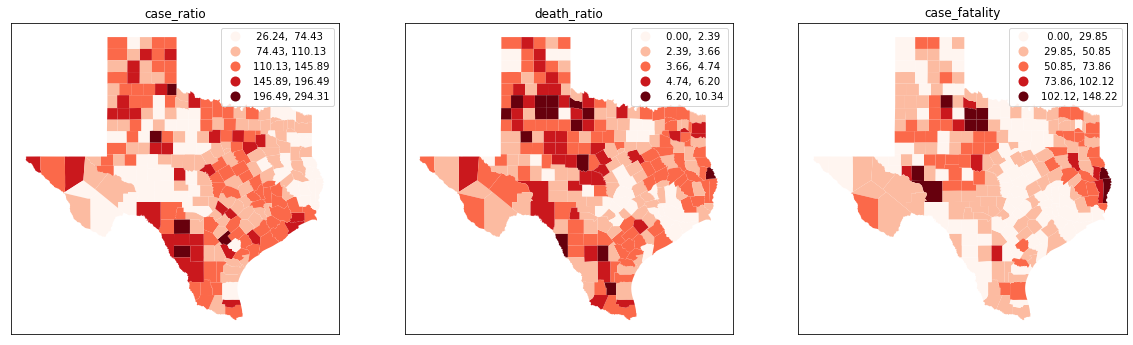

In [10]:
fig, axes = plt.subplots(1,3, figsize=(20, 15))

for idx, val in enumerate(['case_ratio', 'death_ratio', 'case_fatality']):
    county.plot(val, ax=axes[idx], scheme='FisherJenks', cmap='Reds', legend=True)
    
    # Decoration
    axes[idx].get_xaxis().set_visible(False)  # Remove ticks and labels
    axes[idx].get_yaxis().set_visible(False)  # Remove ticks and labels
    axes[idx].set_title(val)
    
plt.show()

## Trend Plot

In [11]:
ave_case = covid_case.copy(deep=True)
ave_death = daily_death.copy(deep=True)

for idx, val in focus_date_dict.items():
    ave_death[idx] = daily_death[val].mean(axis=1)
    ave_case[idx] = covid_case[val].mean(axis=1)
    
ave_case
ave_death

,07/01/2020,07/02/2020,07/03/2020,07/04/2020,07/05/2020,07/06/2020,07/07/2020,07/08/2020,07/09/2020,07/10/2020,...,12/22/2021,12/23/2021,12/24/2021,12/25/2021,12/26/2021,12/27/2021,12/28/2021,12/29/2021,12/30/2021,12/31/2021
County,,,,,,,,,,,,,,,,,,,,,
Anderson,0.25,0.2,0.166667,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,...,0.142857,0.285714,0.285714,0.428571,0.428571,0.285714,0.285714,0.333333,0.2,0.25
Andrews,0.00,0.2,0.166667,0.142857,0.142857,0.142857,0.142857,0.142857,0.000000,0.000000,...,0.142857,0.142857,0.000000,0.142857,0.142857,0.142857,0.142857,0.166667,0.2,0.25
Angelina,0.50,0.4,0.666667,0.571429,0.571429,0.428571,0.571429,0.571429,0.571429,0.571429,...,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.166667,0.2,0.25
Aransas,0.00,0.2,0.166667,0.428571,0.571429,0.571429,0.571429,0.571429,0.428571,0.428571,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00
Archer,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Wood,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.285714,0.285714,0.285714,0.428571,0.285714,0.428571,0.285714,0.333333,0.4,0.50
Yoakum,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.166667,0.2,0.25
Young,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00


In [12]:
ave_case

,07/01/2020,07/02/2020,07/03/2020,07/04/2020,07/05/2020,07/06/2020,07/07/2020,07/08/2020,07/09/2020,07/10/2020,...,12/22/2021,12/23/2021,12/24/2021,12/25/2021,12/26/2021,12/27/2021,12/28/2021,12/29/2021,12/30/2021,12/31/2021
County,,,,,,,,,,,,,,,,,,,,,
Anderson,10.50,8.8,8.000000,8.142857,8.714286,8.000000,9.571429,14.285714,61.857143,95.428571,...,3.857143,3.857143,4.285714,4.285714,6.000000,5.714286,6.000000,5.833333,6.4,6.25
Andrews,2.25,1.8,3.000000,3.000000,3.571429,4.428571,5.285714,5.428571,5.428571,4.571429,...,3.428571,3.285714,3.285714,2.571429,4.428571,6.857143,8.428571,9.833333,11.8,14.75
Angelina,24.75,20.2,18.166667,18.142857,17.428571,11.714286,9.428571,11.285714,12.857143,14.142857,...,5.000000,6.000000,6.428571,6.428571,7.857143,7.857143,10.285714,11.000000,11.8,12.50
Aransas,2.75,3.0,3.000000,2.857143,2.428571,2.428571,3.000000,3.571429,3.142857,3.428571,...,2.285714,2.285714,2.285714,2.857143,2.857143,2.714286,3.142857,2.833333,3.0,3.50
Archer,0.50,0.4,0.500000,0.571429,0.571429,0.571429,0.857143,0.571429,0.571429,0.428571,...,3.000000,2.857143,3.285714,4.000000,4.285714,3.714286,4.857143,5.333333,6.0,6.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Wood,0.50,0.6,0.500000,0.714286,0.857143,0.857143,1.000000,0.857143,0.714286,0.714286,...,6.000000,5.857143,6.857143,3.857143,4.285714,4.000000,4.000000,3.333333,3.8,2.50
Yoakum,0.75,0.8,0.666667,0.714286,0.285714,0.285714,0.285714,0.285714,0.142857,0.142857,...,0.142857,0.142857,0.142857,0.285714,0.428571,0.428571,0.285714,0.333333,0.4,0.50
Young,1.50,1.2,1.166667,1.285714,1.285714,1.142857,1.285714,1.428571,1.571429,1.857143,...,0.714286,0.714286,0.857143,1.714286,1.714286,1.857143,2.142857,2.333333,2.8,3.25


In [13]:
def standardize(ary):
    ary_ = ary.copy()
    ary_ = ary_.astype('float64')
    
    for idx, val in enumerate(ary):
        ary_[idx] = (val - ary.mean()) / ary.std()
        
    return ary_

def normalize(ary):
    ary_ = ary.copy()
    ary_ = ary_.astype('float64')
    
    for idx, val in enumerate(ary):
        ary_[idx] = (val - ary.min()) / (ary.max() - ary.min())
        
    return ary_

In [14]:
trend = pd.DataFrame(index=focus_date_dict.keys())
trend['case'] = ave_case[focus_date_dict.keys()].sum()
trend['death'] = ave_death[focus_date_dict.keys()].sum()
trend['ratio'] = trend['death'] / trend['case'] * 1000
trend['case_norm'] = normalize(trend['case'])
trend['death_norm'] = normalize(trend['death'])
trend['ratio_norm'] = normalize(trend['ratio'])
trend

,case,death,ratio,case_norm,death_norm,ratio_norm
07/01/2020,5615.500000,126.250000,22.482415,0.267093,0.324102,0.336317
07/02/2020,5938.400000,127.400000,21.453590,0.284585,0.327545,0.316175
07/03/2020,6187.666667,131.166667,21.198082,0.298088,0.338822,0.311173
07/04/2020,6402.571429,135.857143,21.219153,0.309730,0.352866,0.311585
07/05/2020,6897.571429,150.857143,21.871052,0.336545,0.397776,0.324348
...,...,...,...,...,...,...
12/27/2021,11614.714286,63.428571,5.461053,0.592080,0.136014,0.003072
12/28/2021,11767.857143,64.142857,5.450683,0.600376,0.138152,0.002869
12/29/2021,11601.166667,67.333333,5.804014,0.591346,0.147705,0.009787
12/30/2021,11895.200000,67.000000,5.632524,0.607274,0.146707,0.006429


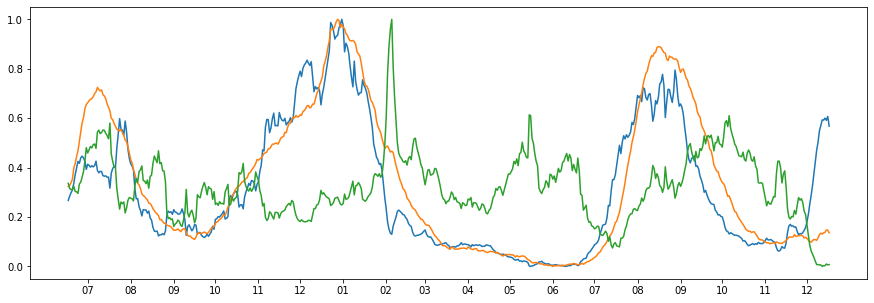

In [15]:
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(trend['case_norm'])
ax.plot(trend['death_norm'])
ax.plot(trend['ratio_norm'])

ax.set_xticks([date for date in focus_date if date[3:5] == '15']) # The locations that ticks will be displayed.
ax.set_xticklabels([date[0:2] for date in focus_date if date[3:5] == '15'])
plt.show()

## Plot Temporal Changes of Accessibility Measures

<AxesSubplot:>

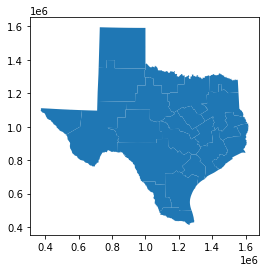

In [16]:
county_boundary = gpd.read_file('./data/plots/ICU_access_county.shp')
county_boundary.set_index('index', inplace=True)
county_boundary = county_boundary.to_crs(epsg=3081)
county_boundary = county_boundary[['geometry']]
county_boundary

tsa_boundary = pd.read_json('./data/original_data/tsa_county.json')
tsa_boundary['FIPS'] = tsa_boundary['FIPS'].astype(str)
tsa_boundary.set_index('FIPS', inplace=True)
tsa_boundary = county_boundary.merge(tsa_boundary, left_index=True, right_index=True)
tsa_boundary = tsa_boundary.dissolve(by='TSA')
tsa_boundary = tsa_boundary.drop(columns='County')
tsa_boundary['geometry'] = tsa_boundary['geometry'].simplify(0.01)
tsa_boundary.plot()

In [17]:
access = gpd.read_file('./data/plots/ICU_access_tract.shp')
access_val = access[focus_date_dict.keys()].values.reshape(-1)
access_val[access_val>1] = 1 # Accessibiltiy more than 1 is unnecessary
map_class_acc = mapclassify.NaturalBreaks(access_val, k=7)
print(map_class_acc.bins)
map_class_acc

[0.02038341 0.0567791  0.11969106 0.23214769 0.4298776  0.73710194
 1.        ]


NaturalBreaks         

  Interval       Count
----------------------
[0.00, 0.02] | 1981082
(0.02, 0.06] |  606068
(0.06, 0.12] |  212679
(0.12, 0.23] |   59571
(0.23, 0.43] |   20898
(0.43, 0.74] |    6716
(0.74, 1.00] |    3471

07/15/2020
08/15/2020
09/15/2020
10/15/2020
11/15/2020
12/15/2020
01/15/2021
02/15/2021
03/15/2021
04/15/2021
05/15/2021
06/15/2021
07/15/2021
08/15/2021
09/15/2021
10/15/2021
11/15/2021
12/15/2021


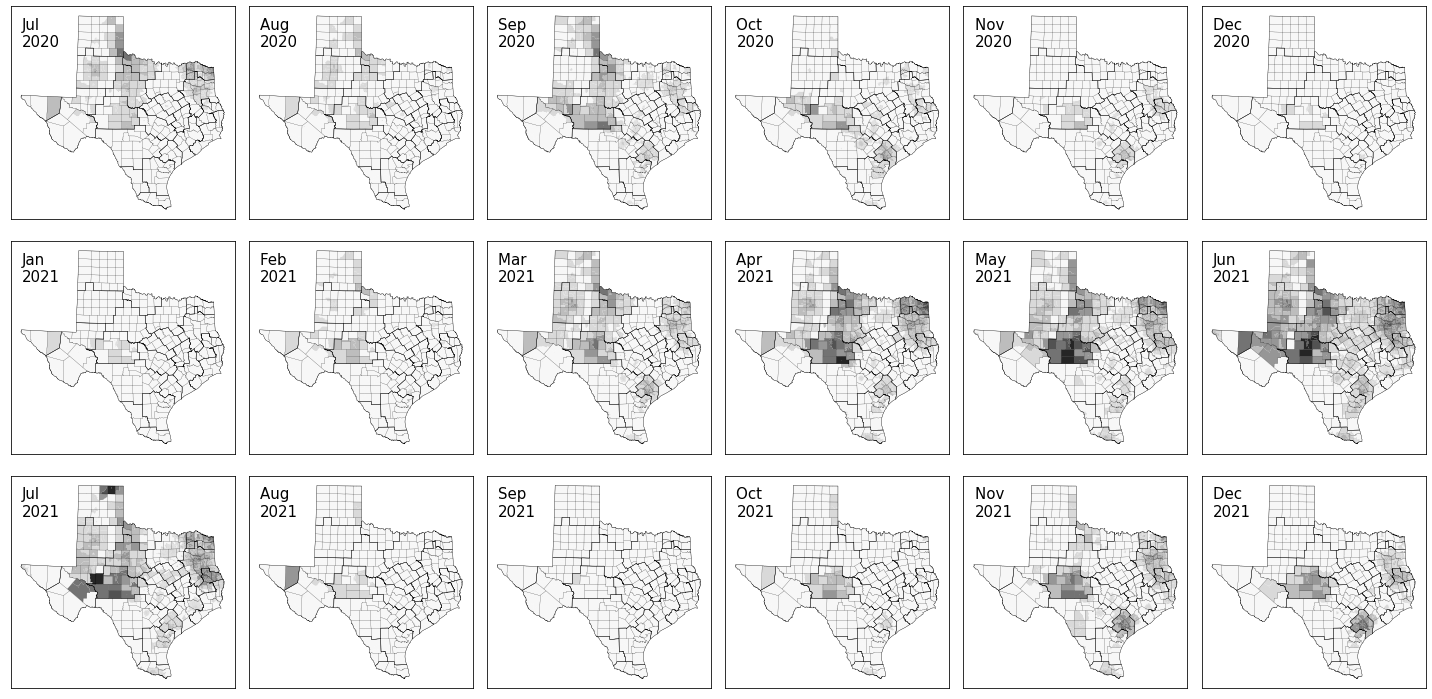

In [18]:
period = ['07/15/2020', '08/15/2020', '09/15/2020', '10/15/2020', '11/15/2020', '12/15/2020',
          '01/15/2021', '02/15/2021', '03/15/2021', '04/15/2021', '05/15/2021', '06/15/2021',
          '07/15/2021', '08/15/2021', '09/15/2021', '10/15/2021', '11/15/2021', '12/15/2021'
         ]
# Define color map
color_brewer = ['#f7f7f7','#d9d9d9','#bdbdbd','#969696','#737373','#525252','#252525']
cm = LinearSegmentedColormap.from_list('cb_', color_brewer, N=7)

fig, axes = plt.subplots(3, 6, figsize=(20,10))
ax = axes.reshape(-1)
for idx, m in enumerate(period):
    print(m)
    access.plot(column=m, 
            ax = ax[idx],
            cmap=cm,
            scheme='user_defined',
            classification_kwds={'bins':map_class_acc.bins} # then speicfy class here.
           )
    tsa_boundary.boundary.plot(ax=ax[idx], lw=0.3, color='black')
    county_boundary.boundary.plot(ax=ax[idx], lw=0.1, color='black')
    
#     ax[idx].set_title(month_text)
    month_text = datetime.datetime.strptime(m, '%m/%d/%Y')
    month_text = month_text.strftime('%b \n%Y')
    ax[idx].text(0.05, 0.95, s=month_text, fontsize=15, ha='left', va='top', transform=ax[idx].transAxes)
    ax[idx].get_xaxis().set_visible(False)
    ax[idx].get_yaxis().set_visible(False)
    
plt.tight_layout() # Will shrink empty area
plt.show()

## Temporal Changes of Mortality rate

In [19]:
if county.index.name != 'NAME':
    county.set_index('NAME', inplace=True)

ave_mortality = ave_death.copy(deep=True)

for date in tqdm(ave_mortality.columns):
    ave_mortality[date] = ave_death[date] / county['pop'] * 100000
    
ave_mortality = ave_mortality.merge(county['geometry'], left_index=True, right_index=True)
ave_mortality = gpd.GeoDataFrame(ave_mortality)
ave_mortality = ave_mortality.to_crs(epsg=3081)

100%|█████████████████████████████████████████| 549/549 [00:00<00:00, 715.25it/s]


In [20]:
ave_mortality_val = ave_mortality[focus_date_dict.keys()].values.reshape(-1)
# map_class_mortality = mapclassify.NaturalBreaks(ave_mortality_val, k=9)
map_class_mortality = mapclassify.NaturalBreaks(ave_mortality_val, k=7)
print(map_class_mortality.bins)
map_class_mortality

[ 0.48907528  1.53510792  3.07371983  5.4745025   8.86540541 16.00416108
 46.60918201]


NaturalBreaks         

   Interval      Count
----------------------
[ 0.00,  0.49] | 91449
( 0.49,  1.54] | 27723
( 1.54,  3.07] | 12776
( 3.07,  5.47] |  5355
( 5.47,  8.87] |  1482
( 8.87, 16.00] |   500
(16.00, 46.61] |   161

07/15/2020
08/15/2020
09/15/2020
10/15/2020
11/15/2020
12/15/2020
01/15/2021
02/15/2021
03/15/2021
04/15/2021
05/15/2021
06/15/2021
07/15/2021
08/15/2021
09/15/2021
10/15/2021
11/15/2021
12/15/2021


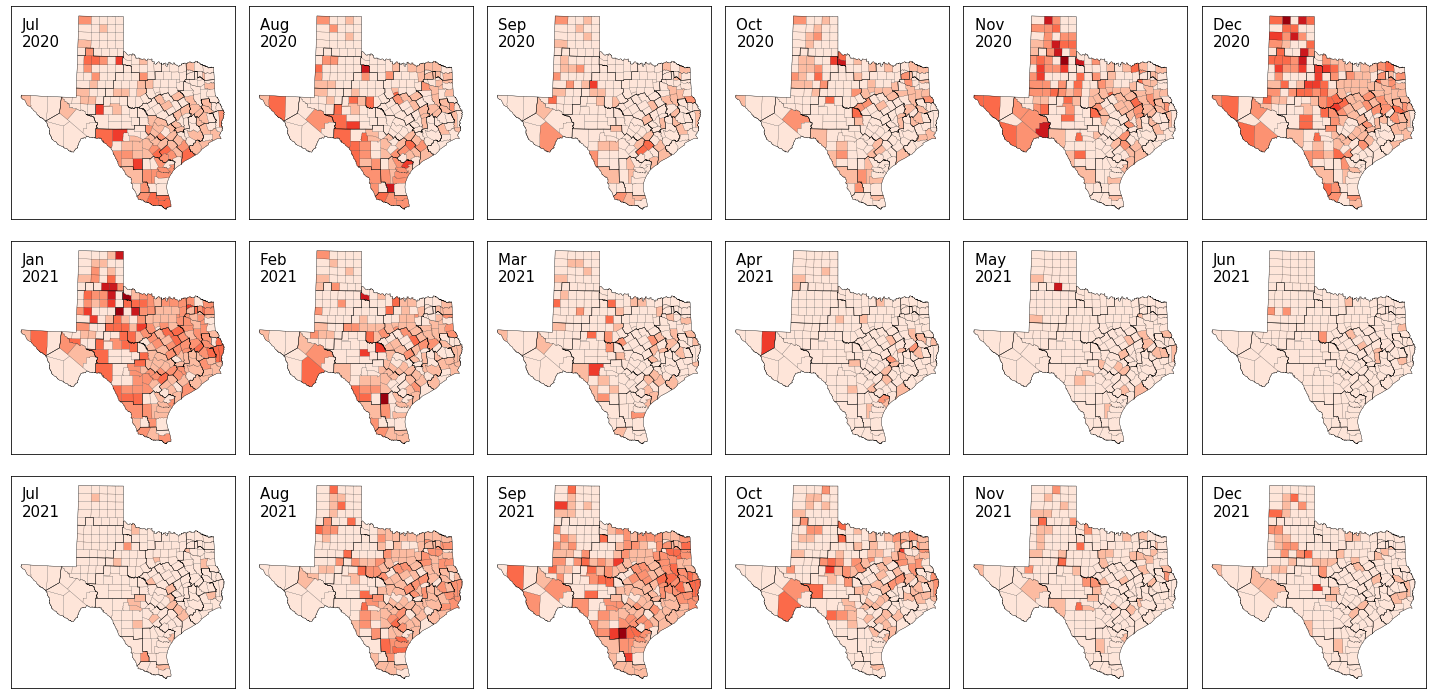

In [21]:
# Define color map
color_brewer = ['#fee5d9','#fcbba1','#fc9272','#fb6a4a','#ef3b2c','#cb181d','#99000d']
cm = LinearSegmentedColormap.from_list('cb_', color_brewer, N=7)

fig, axes = plt.subplots(3, 6, figsize=(20,10))
ax = axes.reshape(-1)

for idx, m in enumerate(period):
    print(m)
    ave_mortality.plot(column=m, 
                       ax = ax[idx],
                       cmap=cm,
                       scheme='user_defined',
                       classification_kwds={'bins':map_class_mortality.bins} # then speicfy class here.
                      )
    tsa_boundary.boundary.plot(ax=ax[idx], lw=0.3, color='black')
    county_boundary.boundary.plot(ax=ax[idx], lw=0.1, color='black')

#     ax[idx].set_title(m)
    month_text = datetime.datetime.strptime(m, '%m/%d/%Y')
    month_text = month_text.strftime('%b \n%Y')
    ax[idx].text(0.05, 0.95, s=month_text, fontsize=15, ha='left', va='top', transform=ax[idx].transAxes)
    ax[idx].get_xaxis().set_visible(False)
    ax[idx].get_yaxis().set_visible(False)
    
plt.tight_layout() # Will shrink empty area
plt.show()